## Loading data and preliminary analysis

In [1]:
# Download Dependencies

%pip install -r '../requirements.txt'

import nltk 

nltk.download('stopwords')
nltk.download('wordnet')

Note: you may need to restart the kernel to use updated packages.


True

In [2]:
# import libraries

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import string
import re
import joblib
import json
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Flatten, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM, LSTM, Input, Embedding, TimeDistributed, Flatten, Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
# Modify Paths

path_to_json = '../Dataset/mentalhealth.json'
path_to_dumps = '../Dumps/'

newpath = path_to_dumps
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [4]:
# load data
with open(path_to_json) as file:
  data = json.load(file)

# data

In [5]:
# convert to dataframes 
 
def frame_data(feat_1,feat_2,is_pattern, data):
  is_pattern = is_pattern
  df = pd.DataFrame(columns=[feat_1,feat_2])

  for intent in data['intents']:
    if is_pattern:
      for pattern in intent['patterns']:
        w = pattern
        data_to_append = {feat_1:w, feat_2:intent['tag']}
        df.loc[len(df)] = data_to_append
        
    else:
      for response in intent['responses']:
        w = response
        data_to_append = {feat_1:w, feat_2:intent['tag']}
        df.loc[len(df)] = data_to_append
  return df

In [6]:
df1 = frame_data('questions','labels',True, data)
# df1.head()

In [7]:
# no of patterns

df1.labels.value_counts(sort=False)

labels
definition            3
affects_whom          2
what_causes           3
recover               2
steps                 2
find_help             2
treatement_options    2
treatment_tips        2
professional_types    2
right_professional    2
Name: count, dtype: int64

In [8]:
df2 = frame_data('response','labels',False, data)
# df2.head()

## Data preprocessing

In [9]:
# preprocessing text

lemmatizer = WordNetLemmatizer()

vocab = Counter()
labels = []
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

def remove_stop_words(tokenizer,df,feature):
    doc_without_stopwords = []
    for entry in df[feature]:
        tokens = tokenizer(entry)
        joblib.dump(tokens,path_to_dumps+'tokens.pkl')
        doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return

In [10]:
def create_vocab(tokenizer,df,feature):
    for entry in df[feature]:
        tokens = tokenizer(entry)   
        vocab.update(tokens)
    joblib.dump(vocab, path_to_dumps+'vocab.pkl')
    return

In [11]:
create_vocab(tokenizer,df1,'questions')

In [12]:
vocab

Counter({'what': 9,
         'doe': 3,
         'it': 2,
         'mean': 1,
         'to': 9,
         'have': 2,
         'mental': 14,
         'illness': 9,
         'is': 4,
         'health': 8,
         'describe': 1,
         'who': 3,
         'affect': 1,
         'affected': 1,
         'by': 1,
         'mentall': 1,
         'cause': 1,
         'lead': 1,
         'how': 7,
         'one': 2,
         'get': 1,
         'mentally': 1,
         'ill': 1,
         'can': 3,
         'people': 1,
         'with': 1,
         'recover': 3,
         'possible': 1,
         'from': 1,
         'know': 1,
         'someone': 1,
         'appears': 1,
         'such': 1,
         'symptom': 2,
         'are': 3,
         'the': 4,
         'step': 1,
         'be': 1,
         'followed': 1,
         'incase': 1,
         'of': 2,
         'find': 4,
         'professional': 6,
         'for': 1,
         'myself': 2,
         'treatment': 3,
         'option': 1,
         'avail

In [13]:
vocab_size = len(vocab)
vocab_size

62

In [14]:
df1.groupby(by='labels',as_index=False).first()['questions']

0                      Who does mental illness affect?
1          What does it mean to have a mental illness?
2    How to find mental health professional for myself
3    What is the difference between mental health p...
4              Can people with mental illness recover?
5    How can I find a mental health professional ri...
6    I know someone who appears to have such symptoms?
7                What treatment options are available?
8                 How to become involved in treatment?
9                          What causes mental illness?
Name: questions, dtype: object

In [15]:
# test_list contains the first element of questions

test_list = list(df1.groupby(by='labels',as_index=False).first()['questions'])
test_list

['Who does mental illness affect?',
 'What does it mean to have a mental illness?',
 'How to find mental health professional for myself',
 'What is the difference between mental health professionals?',
 'Can people with mental illness recover?',
 'How can I find a mental health professional right myself?',
 'I know someone who appears to have such symptoms?',
 'What treatment options are available?',
 'How to become involved in treatment?',
 'What causes mental illness?']

In [16]:
# indices of the testing dataset

test_index = []
for i,_ in enumerate(test_list):
    idx = df1[df1.questions == test_list[i]].index[0]
    test_index.append(idx)
test_index

[3, 0, 12, 18, 8, 20, 10, 14, 16, 5]

In [17]:
# train indices are the all indices minus the testing indices 

train_index = [i for i in df1.index if i not in test_index]
train_index 

[1, 2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 21]

In [18]:
def convert_seq(df,feature):
#     text = ' '.join(list(vocab.keys()))
    t = Tokenizer()
    entries = [entry for entry in df[feature]]
    print(entries)
    print('----')
    t.fit_on_texts(entries)
    joblib.dump(t, path_to_dumps+'tokenizer_t.pkl')   # why a pkl file
    vocab_size = len(t.word_index) +1 # +1 for oov 
    print(t.word_index)
    entries = [entry for entry in df[feature]]
    max_length = max([len(s.split()) for s in entries])
    print('----')
    print("max length of string is : ",max_length)
    print('----')
    encoded = t.texts_to_sequences(entries)
    print(encoded)
    padded = pad_sequences(encoded, maxlen=max_length, padding='post')
    print('----')
    print(padded)
    return padded, vocab_size

**fit_on_texts** updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).

Now that we have a vocabulary of words in the dataset, **each of the patterns can be encoded into numerical features for modeling, using any of the common text encoding techniques—count vectorizer**, term frequency-inverse document frequency (TF-IDF), hashing, etc.

Using TensorFlow.Keras text_to_sequence, we can **encode each pattern corpus to vectorize a text corpus by turning each text into either a sequence of integers** (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count which is based on TF-IDF. The resulting vectors will be post-padded with zeros so as to equal the length of the vectors.

In [19]:
X,vocab_size = convert_seq(df1,'questions')

['What does it mean to have a mental illness?', 'What is mental health illness', 'Describe mental health illness', 'Who does mental illness affect?', 'Who is affected by mentall illness', 'What causes mental illness?', 'What leads to mental illness?', 'how does one get mentally ill?', 'Can people with mental illness recover?', 'Is it possible to recover from mental illness', 'I know someone who appears to have such symptoms?', 'What are the steps to be followed incase of symptoms', 'How to find mental health professional for myself', 'How to find mental health professional?', 'What treatment options are available?', 'How can one recover?', 'How to become involved in treatment?', 'What should I keep in mind if I begin treatment?', 'What is the difference between mental health professionals?', 'What are the different types of mental health professionals present?', 'How can I find a mental health professional right myself?', 'How to find the right mental health professional?']
----
{'ment

In [20]:
with open(path_to_dumps+'tokenizer_t.pkl', 'rb') as f:
    data = pickle.load(f)

In [21]:
data.index_word

{1: 'mental',
 2: 'what',
 3: 'to',
 4: 'illness',
 5: 'health',
 6: 'how',
 7: 'is',
 8: 'i',
 9: 'the',
 10: 'find',
 11: 'professional',
 12: 'does',
 13: 'who',
 14: 'can',
 15: 'recover',
 16: 'are',
 17: 'treatment',
 18: 'it',
 19: 'have',
 20: 'a',
 21: 'one',
 22: 'symptoms',
 23: 'of',
 24: 'myself',
 25: 'in',
 26: 'professionals',
 27: 'right',
 28: 'mean',
 29: 'describe',
 30: 'affect',
 31: 'affected',
 32: 'by',
 33: 'mentall',
 34: 'causes',
 35: 'leads',
 36: 'get',
 37: 'mentally',
 38: 'ill',
 39: 'people',
 40: 'with',
 41: 'possible',
 42: 'from',
 43: 'know',
 44: 'someone',
 45: 'appears',
 46: 'such',
 47: 'steps',
 48: 'be',
 49: 'followed',
 50: 'incase',
 51: 'for',
 52: 'options',
 53: 'available',
 54: 'become',
 55: 'involved',
 56: 'should',
 57: 'keep',
 58: 'mind',
 59: 'if',
 60: 'begin',
 61: 'difference',
 62: 'between',
 63: 'different',
 64: 'types',
 65: 'present'}

In [22]:
data.word_counts

OrderedDict([('what', 9),
             ('does', 3),
             ('it', 2),
             ('mean', 1),
             ('to', 9),
             ('have', 2),
             ('a', 2),
             ('mental', 14),
             ('illness', 9),
             ('is', 4),
             ('health', 8),
             ('describe', 1),
             ('who', 3),
             ('affect', 1),
             ('affected', 1),
             ('by', 1),
             ('mentall', 1),
             ('causes', 1),
             ('leads', 1),
             ('how', 7),
             ('one', 2),
             ('get', 1),
             ('mentally', 1),
             ('ill', 1),
             ('can', 3),
             ('people', 1),
             ('with', 1),
             ('recover', 3),
             ('possible', 1),
             ('from', 1),
             ('i', 4),
             ('know', 1),
             ('someone', 1),
             ('appears', 1),
             ('such', 1),
             ('symptoms', 2),
             ('are', 3),
            

In [23]:
X

array([[ 2, 12, 18, 28,  3, 19, 20,  1,  4,  0],
       [ 2,  7,  1,  5,  4,  0,  0,  0,  0,  0],
       [29,  1,  5,  4,  0,  0,  0,  0,  0,  0],
       [13, 12,  1,  4, 30,  0,  0,  0,  0,  0],
       [13,  7, 31, 32, 33,  4,  0,  0,  0,  0],
       [ 2, 34,  1,  4,  0,  0,  0,  0,  0,  0],
       [ 2, 35,  3,  1,  4,  0,  0,  0,  0,  0],
       [ 6, 12, 21, 36, 37, 38,  0,  0,  0,  0],
       [14, 39, 40,  1,  4, 15,  0,  0,  0,  0],
       [ 7, 18, 41,  3, 15, 42,  1,  4,  0,  0],
       [ 8, 43, 44, 13, 45,  3, 19, 46, 22,  0],
       [ 2, 16,  9, 47,  3, 48, 49, 50, 23, 22],
       [ 6,  3, 10,  1,  5, 11, 51, 24,  0,  0],
       [ 6,  3, 10,  1,  5, 11,  0,  0,  0,  0],
       [ 2, 17, 52, 16, 53,  0,  0,  0,  0,  0],
       [ 6, 14, 21, 15,  0,  0,  0,  0,  0,  0],
       [ 6,  3, 54, 55, 25, 17,  0,  0,  0,  0],
       [ 2, 56,  8, 57, 25, 58, 59,  8, 60, 17],
       [ 2,  7,  9, 61, 62,  1,  5, 26,  0,  0],
       [ 2, 16,  9, 63, 64, 23,  1,  5, 26, 65],
       [ 6, 14,  8, 

In [24]:
vocab_size

66

In [25]:
df_encoded = pd.DataFrame(X)

In [26]:
df_encoded

,0,1,2,3,4,5,6,7,8,9
0,2,12,18,28,3,19,20,1,4,0
1,2,7,1,5,4,0,0,0,0,0
2,29,1,5,4,0,0,0,0,0,0
3,13,12,1,4,30,0,0,0,0,0
4,13,7,31,32,33,4,0,0,0,0
5,2,34,1,4,0,0,0,0,0,0
6,2,35,3,1,4,0,0,0,0,0
7,6,12,21,36,37,38,0,0,0,0
8,14,39,40,1,4,15,0,0,0,0
9,7,18,41,3,15,42,1,4,0,0


In [27]:
df1.head(10)

,questions,labels
0,What does it mean to have a mental illness?,definition
1,What is mental health illness,definition
2,Describe mental health illness,definition
3,Who does mental illness affect?,affects_whom
4,Who is affected by mentall illness,affects_whom
5,What causes mental illness?,what_causes
6,What leads to mental illness?,what_causes
7,how does one get mentally ill?,what_causes
8,Can people with mental illness recover?,recover
9,Is it possible to recover from mental illness,recover


In [28]:
df_encoded['labels'] = df1.labels
df_encoded.head(10)

,0,1,2,3,4,5,6,7,8,9,labels
0,2,12,18,28,3,19,20,1,4,0,definition
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
3,13,12,1,4,30,0,0,0,0,0,affects_whom
4,13,7,31,32,33,4,0,0,0,0,affects_whom
5,2,34,1,4,0,0,0,0,0,0,what_causes
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
8,14,39,40,1,4,15,0,0,0,0,recover
9,7,18,41,3,15,42,1,4,0,0,recover


In [29]:
df_encoded

,0,1,2,3,4,5,6,7,8,9,labels
0,2,12,18,28,3,19,20,1,4,0,definition
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
3,13,12,1,4,30,0,0,0,0,0,affects_whom
4,13,7,31,32,33,4,0,0,0,0,affects_whom
5,2,34,1,4,0,0,0,0,0,0,what_causes
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
8,14,39,40,1,4,15,0,0,0,0,recover
9,7,18,41,3,15,42,1,4,0,0,recover


In [30]:
lable_enc = LabelEncoder()

# encoding the labels

labl = lable_enc.fit_transform(df_encoded.labels)
labl

array([1, 1, 1, 0, 0, 9, 9, 9, 4, 4, 6, 6, 2, 2, 7, 7, 8, 8, 3, 3, 5, 5])

In [31]:
len(labl)

22

In [32]:
mapper = {}
for index,key in enumerate(df_encoded.labels):
    if key not in mapper.keys():
        mapper[key] = labl[index]
mapper

{'definition': 1,
 'affects_whom': 0,
 'what_causes': 9,
 'recover': 4,
 'steps': 6,
 'find_help': 2,
 'treatement_options': 7,
 'treatment_tips': 8,
 'professional_types': 3,
 'right_professional': 5}

Repeat the same for df2

In [33]:
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,definition
1,It is estimated that mental illness affects 1 ...,affects_whom
2,Symptoms of mental health disorders vary depen...,what_causes
3,"When healing from mental illness, early identi...",recover
4,Although this website cannot substitute for pr...,steps


In [34]:
df2

,response,labels
0,Mental illnesses are health conditions that di...,definition
1,It is estimated that mental illness affects 1 ...,affects_whom
2,Symptoms of mental health disorders vary depen...,what_causes
3,"When healing from mental illness, early identi...",recover
4,Although this website cannot substitute for pr...,steps
5,Feeling comfortable with the professional you ...,find_help
6,Just as there are different types of medicatio...,treatement_options
7,Since beginning treatment is a big step for in...,treatment_tips
8,There are many types of mental health professi...,professional_types
9,Feeling comfortable with the professional you ...,right_professional


In [35]:
df2.labels = df2.labels.map(mapper).astype({'labels': 'int32'})
df2.head()

,response,labels
0,Mental illnesses are health conditions that di...,1
1,It is estimated that mental illness affects 1 ...,0
2,Symptoms of mental health disorders vary depen...,9
3,"When healing from mental illness, early identi...",4
4,Although this website cannot substitute for pr...,6


In [36]:
df2.to_csv('response.csv',index=False)

In [37]:
df_encoded.head()

,0,1,2,3,4,5,6,7,8,9,labels
0,2,12,18,28,3,19,20,1,4,0,definition
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
3,13,12,1,4,30,0,0,0,0,0,affects_whom
4,13,7,31,32,33,4,0,0,0,0,affects_whom


In [38]:
train_index

[1, 2, 4, 6, 7, 9, 11, 13, 15, 17, 19, 21]

In [39]:
test_index

[3, 0, 12, 18, 8, 20, 10, 14, 16, 5]

In [40]:
train = df_encoded.loc[train_index]
test = df_encoded.loc[test_index]

## Training and testing

In [41]:
train

,0,1,2,3,4,5,6,7,8,9,labels
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
4,13,7,31,32,33,4,0,0,0,0,affects_whom
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
9,7,18,41,3,15,42,1,4,0,0,recover
11,2,16,9,47,3,48,49,50,23,22,steps
13,6,3,10,1,5,11,0,0,0,0,find_help
15,6,14,21,15,0,0,0,0,0,0,treatement_options
17,2,56,8,57,25,58,59,8,60,17,treatment_tips


In [42]:
test.head()

,0,1,2,3,4,5,6,7,8,9,labels
3,13,12,1,4,30,0,0,0,0,0,affects_whom
0,2,12,18,28,3,19,20,1,4,0,definition
12,6,3,10,1,5,11,51,24,0,0,find_help
18,2,7,9,61,62,1,5,26,0,0,professional_types
8,14,39,40,1,4,15,0,0,0,0,recover


In [43]:
train.labels.value_counts()

labels
definition            2
what_causes           2
affects_whom          1
recover               1
steps                 1
find_help             1
treatement_options    1
treatment_tips        1
professional_types    1
right_professional    1
Name: count, dtype: int64

In [44]:
test.labels.value_counts()

labels
affects_whom          1
definition            1
find_help             1
professional_types    1
recover               1
right_professional    1
steps                 1
treatement_options    1
treatment_tips        1
what_causes           1
Name: count, dtype: int64

In [45]:
train

,0,1,2,3,4,5,6,7,8,9,labels
1,2,7,1,5,4,0,0,0,0,0,definition
2,29,1,5,4,0,0,0,0,0,0,definition
4,13,7,31,32,33,4,0,0,0,0,affects_whom
6,2,35,3,1,4,0,0,0,0,0,what_causes
7,6,12,21,36,37,38,0,0,0,0,what_causes
9,7,18,41,3,15,42,1,4,0,0,recover
11,2,16,9,47,3,48,49,50,23,22,steps
13,6,3,10,1,5,11,0,0,0,0,find_help
15,6,14,21,15,0,0,0,0,0,0,treatement_options
17,2,56,8,57,25,58,59,8,60,17,treatment_tips


In [46]:
X_train = train.drop(columns=['labels'],axis=1)
y_train = train.labels
X_test = test.drop(columns=['labels'],axis=1)
y_test = test.labels

In [47]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9
1,2,7,1,5,4,0,0,0,0,0
2,29,1,5,4,0,0,0,0,0,0
4,13,7,31,32,33,4,0,0,0,0
6,2,35,3,1,4,0,0,0,0,0
7,6,12,21,36,37,38,0,0,0,0


In [48]:
y_train =pd.get_dummies(y_train).values
y_test =pd.get_dummies(y_test).values

In [49]:
X_test

,0,1,2,3,4,5,6,7,8,9
3,13,12,1,4,30,0,0,0,0,0
0,2,12,18,28,3,19,20,1,4,0
12,6,3,10,1,5,11,51,24,0,0
18,2,7,9,61,62,1,5,26,0,0
8,14,39,40,1,4,15,0,0,0,0
20,6,14,8,10,20,1,5,11,27,24
10,8,43,44,13,45,3,19,46,22,0
14,2,17,52,16,53,0,0,0,0,0
16,6,3,54,55,25,17,0,0,0,0
5,2,34,1,4,0,0,0,0,0,0


In [50]:
X_train

,0,1,2,3,4,5,6,7,8,9
1,2,7,1,5,4,0,0,0,0,0
2,29,1,5,4,0,0,0,0,0,0
4,13,7,31,32,33,4,0,0,0,0
6,2,35,3,1,4,0,0,0,0,0
7,6,12,21,36,37,38,0,0,0,0
9,7,18,41,3,15,42,1,4,0,0
11,2,16,9,47,3,48,49,50,23,22
13,6,3,10,1,5,11,0,0,0,0
15,6,14,21,15,0,0,0,0,0,0
17,2,56,8,57,25,58,59,8,60,17


In [51]:
y_train

array([[False,  True, False, False, False, False, False, False, False,
        False],
       [False,  True, False, False, False, False, False, False, False,
        False],
       [ True, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
         True],
       [False, False, False, False, False, False, False, False, False,
         True],
       [False, False, False, False,  True, False, False, False, False,
        False],
       [False, False, False, False, False, False,  True, False, False,
        False],
       [False, False,  True, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False,  True, False,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, False, False,  True, False, False, False, False, False,
        False],
       [False, False, False, False, False, 

In [52]:
y_train[0]

array([False,  True, False, False, False, False, False, False, False,
       False])

In [53]:
y_test

array([[ True, False, False, False, False, False, False, False, False,
        False],
       [False,  True, False, False, False, False, False, False, False,
        False],
       [False, False,  True, False, False, False, False, False, False,
        False],
       [False, False, False,  True, False, False, False, False, False,
        False],
       [False, False, False, False,  True, False, False, False, False,
        False],
       [False, False, False, False, False,  True, False, False, False,
        False],
       [False, False, False, False, False, False,  True, False, False,
        False],
       [False, False, False, False, False, False, False,  True, False,
        False],
       [False, False, False, False, False, False, False, False,  True,
        False],
       [False, False, False, False, False, False, False, False, False,
         True]])

In [54]:
y_train[0].shape,y_test[0].shape

((10,), (10,))

In [55]:
X_train.shape

(12, 10)

In [56]:
X_test.shape

(10, 10)

In [57]:
max_length = X_train.shape[1]
output = 16                  # no of classes

Reference for the model below:

*   https://keras.io/api/callbacks/model_checkpoint/
*   https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

In [58]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10) #patience : number of epochs with no improvement after which training will be stopped

checkpoint = ModelCheckpoint("model-v1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [early_stopping,checkpoint,reduce_lr]

References : 
* Word embeddings - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
* 2D CNN when we have 3D features, such as RGB - 
https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/
* Pooling layers reduce the size of the representation to speed up the computation and make features robust
* Add a "flatten" layer which prepares a vector for the fully connected layers, for example using Sequential.add(Flatten()) -  
https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/
* Dense layer - A fully connected layer also known as the dense layer, in which the results of the convolutional layers are fed through one or more neural layers to generate a prediction
* Activation functions - https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6 

## Vanilla RNN

* Why use embedding layer before RNN/ LSTM layer -
https://towardsdatascience.com/deep-learning-4-embedding-layers-f9a02d55ac12
* Learning curves - https://www.dataquest.io/blog/learning-curves-machine-learning/





In [59]:
def define_model1(vocab_size, max_length):
    model1 = Sequential()
    model1.add(Embedding(vocab_size,100, input_length=max_length))
    model1.add(SimpleRNN(100))
    model1.add(Dense(10, activation='softmax'))   
    
    model1.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model1.summary()
    plot_model(model1, to_file='model_1.png', show_shapes=True)
    return model1

In [60]:
model1 = define_model1(vocab_size, max_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 100)           6600      
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 27710 (108.24 KB)
Trainable params: 27710 (108.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [61]:
history1 = model1.fit(X_train, y_train, epochs=10, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)#,callbacks=callbacks)

Epoch 1/10
1/1 [==============================] - ETA: 0s - loss: 2.3133 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 2.24612, saving model to model-v1.h5
1/1 [==============================] - 1s 858ms/step - loss: 2.3133 - accuracy: 0.0000e+00 - val_loss: 2.2461 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/10
1/1 [==============================] - ETA: 0s - loss: 2.1745 - accuracy: 0.3333
Epoch 2: val_loss improved from 2.24612 to 2.22545, saving model to model-v1.h5
1/1 [==============================] - 0s 30ms/step - loss: 2.1745 - accuracy: 0.3333 - val_loss: 2.2255 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/10
1/1 [==============================] - ETA: 0s - loss: 2.0396 - accuracy: 0.8333
Epoch 3: val_loss improved from 2.22545 to 2.20654, saving model to model-v1.h5
1/1 [==============================] - 0s 44ms/step - loss: 2.0396 - accuracy: 0.8333 - val_loss: 2.2065 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/10
1/1 [==============================] - ETA: 0

/Users/anuradha.pandey/anaconda3/envs/mental_health/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - ETA: 0s - loss: 1.5020 - accuracy: 0.9167
Epoch 7: val_loss improved from 2.15924 to 2.14641, saving model to model-v1.h5
1/1 [==============================] - 0s 26ms/step - loss: 1.5020 - accuracy: 0.9167 - val_loss: 2.1464 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 8/10
1/1 [==============================] - ETA: 0s - loss: 1.3643 - accuracy: 1.0000
Epoch 8: val_loss improved from 2.14641 to 2.13428, saving model to model-v1.h5
1/1 [==============================] - 0s 26ms/step - loss: 1.3643 - accuracy: 1.0000 - val_loss: 2.1343 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 9/10
1/1 [==============================] - ETA: 0s - loss: 1.2253 - accuracy: 1.0000
Epoch 9: val_loss improved from 2.13428 to 2.12216, saving model to model-v1.h5
1/1 [==============================] - 0s 26ms/step - loss: 1.2253 - accuracy: 1.0000 - val_loss: 2.1222 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 10/10
1/1 [==============================] - ETA: 0s - loss: 1.085

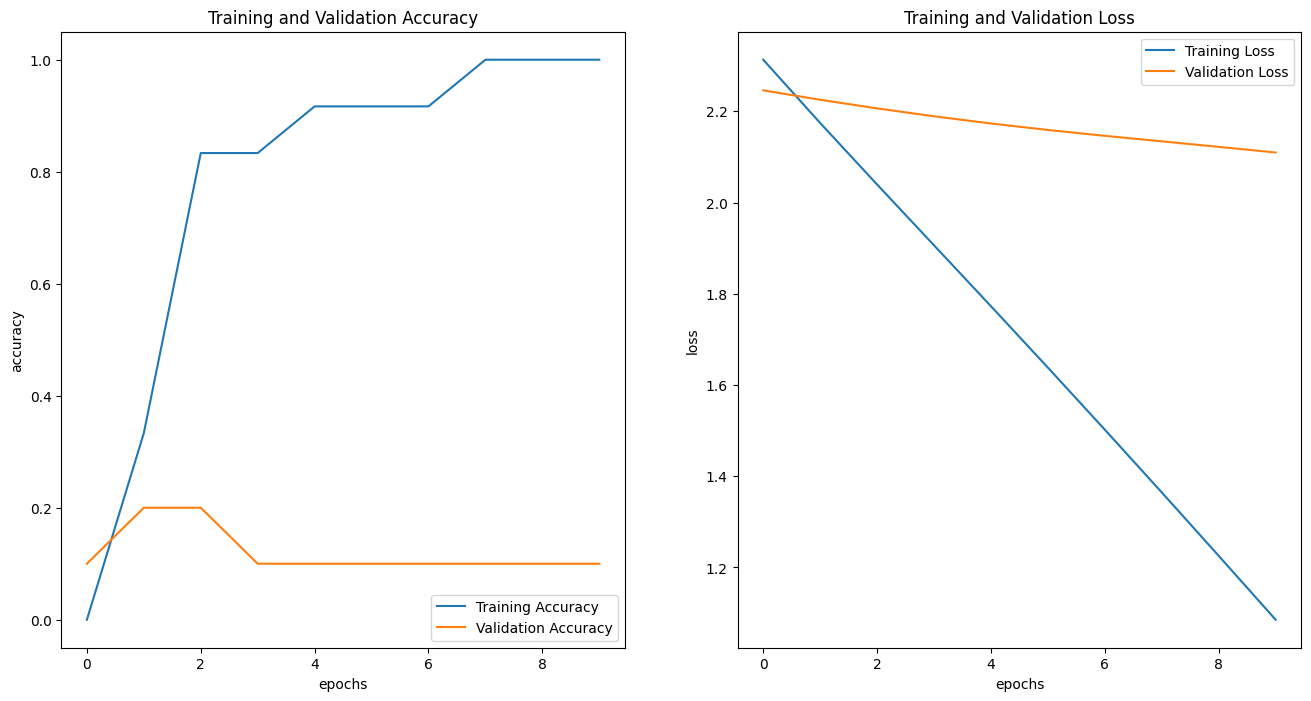

In [62]:
# Learning curves 

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## CNN

In [63]:
def define_model2(vocab_size, max_length):
    model2 = Sequential()
    model2.add(Embedding(vocab_size,300, input_length=max_length))
    model2.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model2.add(MaxPooling1D(pool_size = 4))
    model2.add(Flatten())
    model2.add(Dense(32, activation='relu'))
    model2.add(Dense(10, activation='softmax'))
    
    model2.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model2.summary()
    return model2

In [64]:
model2 = define_model2(vocab_size, max_length)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 300)           19800     
                                                                 
 conv1d (Conv1D)             (None, 9, 32)             19232     
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 32)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                      

In [65]:
history = model2.fit(X_train, y_train, epochs=15, verbose=1,validation_data=(X_test,y_test),callbacks=callbacks)

Epoch 1/15
1/1 [==============================] - ETA: 0s - loss: 2.3108 - accuracy: 0.0833
Epoch 1: val_loss did not improve from 2.10980
1/1 [==============================] - 0s 364ms/step - loss: 2.3108 - accuracy: 0.0833 - val_loss: 2.3017 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/15
1/1 [==============================] - ETA: 0s - loss: 2.2664 - accuracy: 0.4167
Epoch 2: val_loss did not improve from 2.10980
1/1 [==============================] - 0s 18ms/step - loss: 2.2664 - accuracy: 0.4167 - val_loss: 2.2972 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/15
1/1 [==============================] - ETA: 0s - loss: 2.2331 - accuracy: 0.4167
Epoch 3: val_loss did not improve from 2.10980
1/1 [==============================] - 0s 18ms/step - loss: 2.2331 - accuracy: 0.4167 - val_loss: 2.2930 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/15
1/1 [==============================] - ETA: 0s - loss: 2.2032 - accuracy: 0.5000
Epoch 4: val_loss did not improve from 2.10980
1/1 [===============

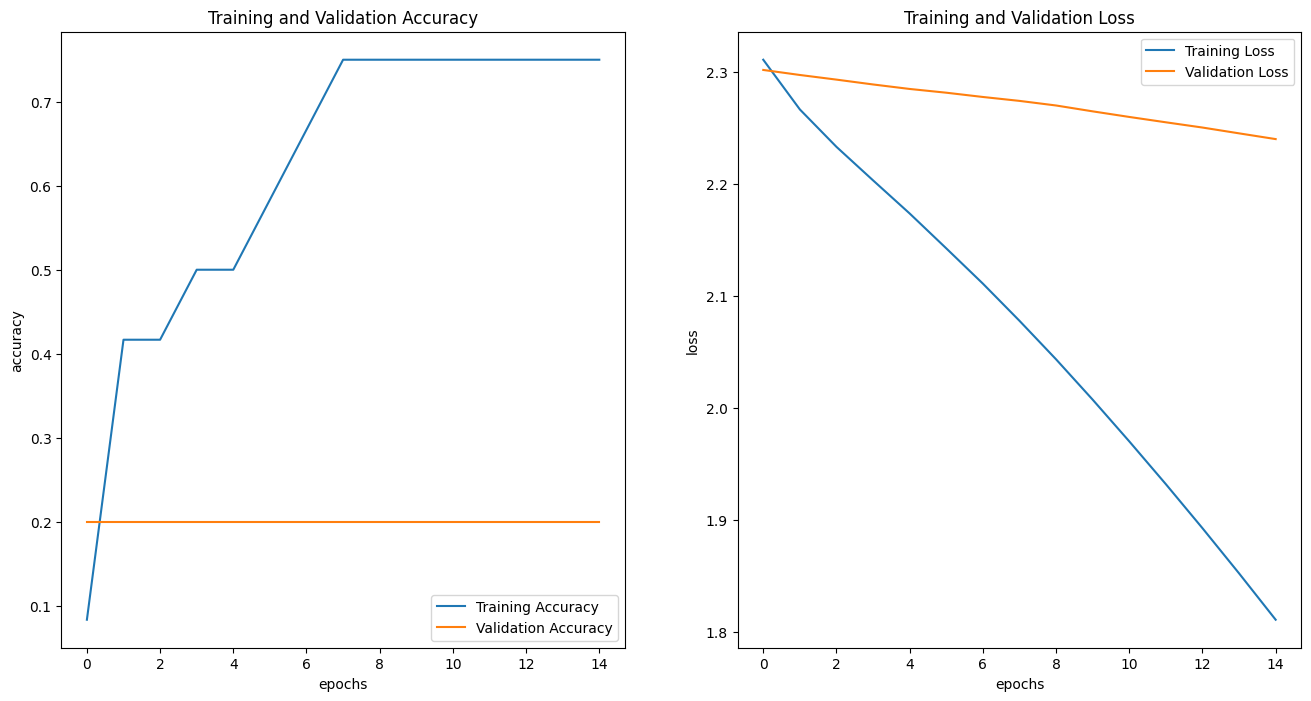

In [66]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## LSTM

In [67]:
def define_model3(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(LSTM(500))
    model3.add(Dense(10, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    return model3

In [68]:
model3 = define_model3(vocab_size, max_length)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 300)           19800     
                                                                 
 lstm (LSTM)                 (None, 500)               1602000   
                                                                 
 dense_3 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1626810 (6.21 MB)
Trainable params: 1626810 (6.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
history = model3.fit(X_train, y_train, epochs=15, verbose=1,validation_data=(X_test,y_test))

Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 2.2959 - accuracy: 0.3333 - val_loss: 2.2928 - val_accuracy: 0.2000
Epoch 2/15
1/1 [==============================] - 0s 46ms/step - loss: 2.2423 - accuracy: 0.5000 - val_loss: 2.2842 - val_accuracy: 0.1000
Epoch 3/15
1/1 [==============================] - 0s 44ms/step - loss: 2.1854 - accuracy: 0.5000 - val_loss: 2.2782 - val_accuracy: 0.1000
Epoch 4/15
1/1 [==============================] - 0s 44ms/step - loss: 2.1187 - accuracy: 0.5000 - val_loss: 2.2797 - val_accuracy: 0.1000
Epoch 5/15
1/1 [==============================] - 0s 44ms/step - loss: 2.0375 - accuracy: 0.5000 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 6/15
1/1 [==============================] - 0s 44ms/step - loss: 1.9434 - accuracy: 0.4167 - val_loss: 2.3677 - val_accuracy: 0.1000
Epoch 7/15
1/1 [==============================] - 0s 44ms/step - loss: 1.8487 - accuracy: 0.4167 - val_loss: 2.4466 - val_accuracy: 0.0000e+00
Epoch 8/15
1/1 [=========

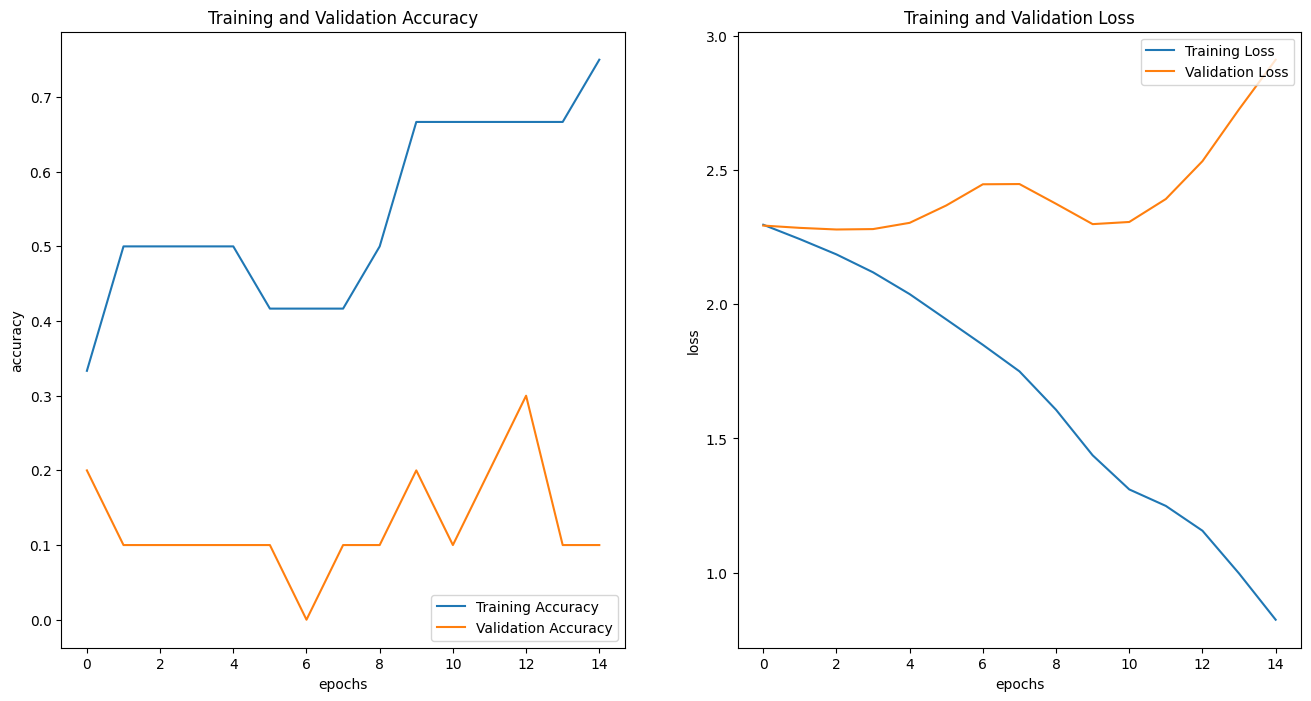

In [70]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## GRU

In [71]:
def define_model3(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(GRU(500))
    model3.add(Dense(10, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    return model3

In [72]:
model3 = define_model3(vocab_size, max_length)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 300)           19800     
                                                                 
 gru (GRU)                   (None, 500)               1203000   
                                                                 
 dense_4 (Dense)             (None, 10)                5010      
                                                                 
Total params: 1227810 (4.68 MB)
Trainable params: 1227810 (4.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
history = model3.fit(X_train, y_train, epochs=15, verbose=1,validation_data=(X_test,y_test))

Epoch 1/15
1/1 [==============================] - 1s 1s/step - loss: 2.2984 - accuracy: 0.2500 - val_loss: 2.2994 - val_accuracy: 0.1000
Epoch 2/15
1/1 [==============================] - 0s 42ms/step - loss: 2.2320 - accuracy: 0.4167 - val_loss: 2.3012 - val_accuracy: 0.1000
Epoch 3/15
1/1 [==============================] - 0s 42ms/step - loss: 2.1667 - accuracy: 0.4167 - val_loss: 2.3114 - val_accuracy: 0.1000
Epoch 4/15
1/1 [==============================] - 0s 41ms/step - loss: 2.0985 - accuracy: 0.4167 - val_loss: 2.3362 - val_accuracy: 0.1000
Epoch 5/15
1/1 [==============================] - 0s 39ms/step - loss: 2.0273 - accuracy: 0.4167 - val_loss: 2.3836 - val_accuracy: 0.1000
Epoch 6/15
1/1 [==============================] - 0s 41ms/step - loss: 1.9567 - accuracy: 0.4167 - val_loss: 2.4494 - val_accuracy: 0.2000
Epoch 7/15
1/1 [==============================] - 0s 42ms/step - loss: 1.8872 - accuracy: 0.4167 - val_loss: 2.4948 - val_accuracy: 0.2000
Epoch 8/15
1/1 [=============

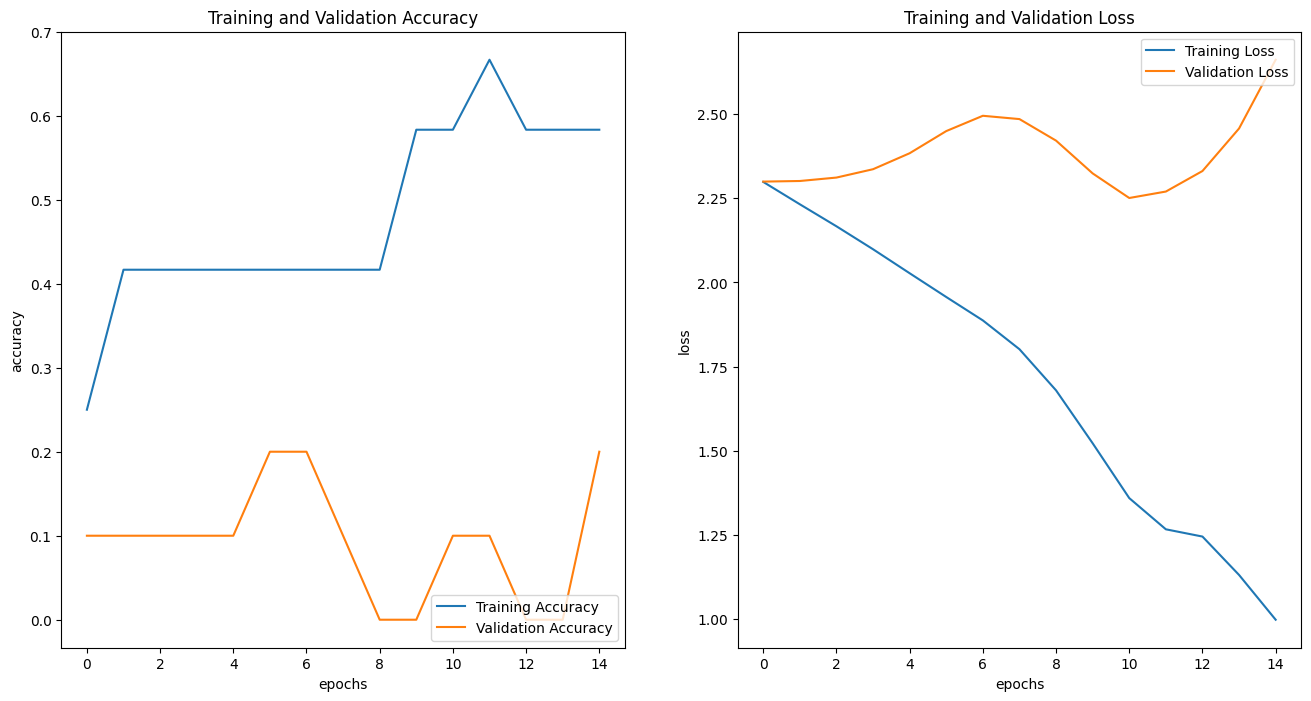

In [74]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## BiLSTM


In [75]:
def define_model3(vocab_size, max_length):
    model3 = Sequential()
    model3.add(Embedding(vocab_size,300, input_length=max_length))
    model3.add(Bidirectional(LSTM(500)))
    model3.add(Dense(10, activation='softmax'))
    
    model3.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    
    # summarize defined model
    model3.summary()
    return model3

In [76]:
model3 = define_model3(vocab_size, max_length)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 300)           19800     
                                                                 
 bidirectional (Bidirection  (None, 1000)              3204000   
 al)                                                             
                                                                 
 dense_5 (Dense)             (None, 10)                10010     
                                                                 
Total params: 3233810 (12.34 MB)
Trainable params: 3233810 (12.34 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
X_train.shape

(12, 10)

In [78]:
y_train.shape

(12, 10)

In [79]:
history = model3.fit(X_train, y_train, epochs=10, verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 2.3005 - accuracy: 0.0833 - val_loss: 2.2893 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 62ms/step - loss: 2.2313 - accuracy: 0.5000 - val_loss: 2.2789 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 64ms/step - loss: 2.1576 - accuracy: 0.5000 - val_loss: 2.2729 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 67ms/step - loss: 2.0696 - accuracy: 0.5000 - val_loss: 2.2836 - val_accuracy: 0.1000
Epoch 5/10
1/1 [==============================] - 0s 70ms/step - loss: 1.9613 - accuracy: 0.5000 - val_loss: 2.3534 - val_accuracy: 0.1000
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 1.8449 - accuracy: 0.5000 - val_loss: 2.5315 - val_accuracy: 0.1000
Epoch 7/10
1/1 [==============================] - 0s 81ms/step - loss: 1.7580 - accuracy: 0.5000 - val_loss: 2.5346 - val_accuracy: 0.1000
Epoch 8/10
1/1 [=

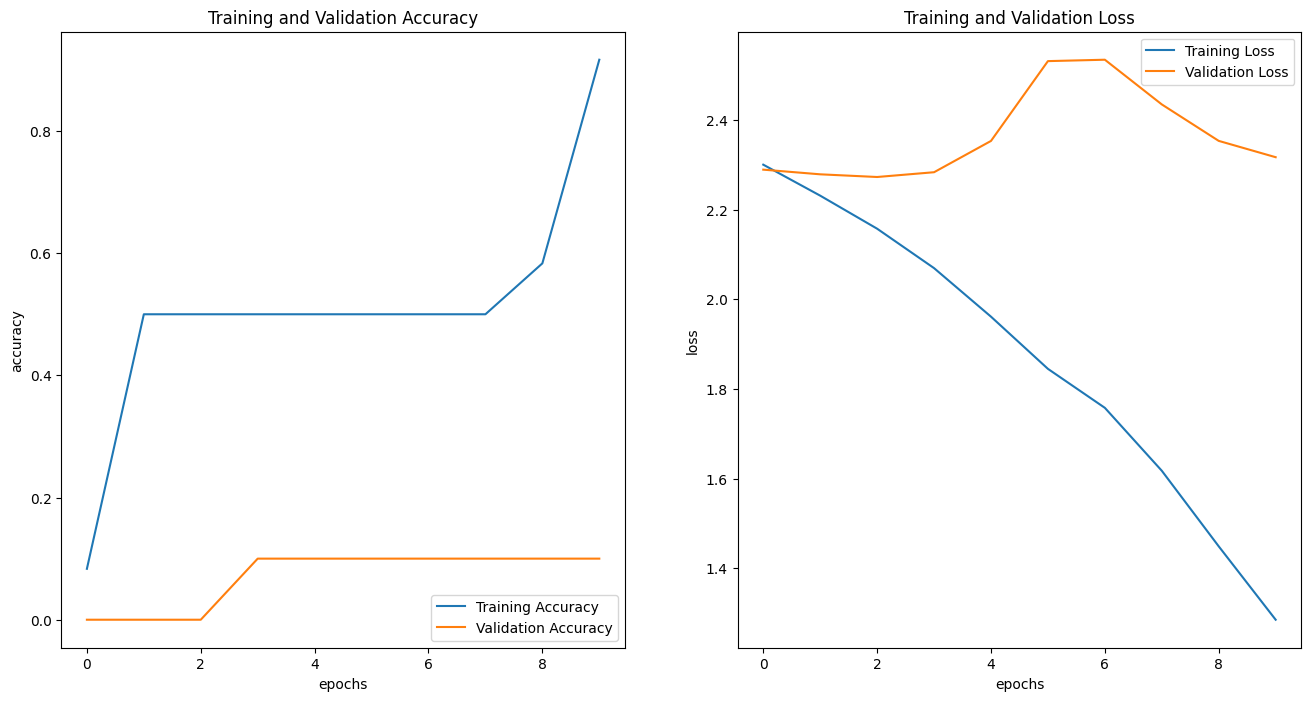

In [80]:
# Learning curves 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Future scope -
* embedding layer : GloVe
* cross validation for testing
* grid search CV

## Predictions

In [81]:
tf.get_logger().setLevel('ERROR')

In [82]:
def get_text(str_text):
    # print(str_text)
    input_text  = [str_text]
    df_input = pd.DataFrame(input_text,columns=['questions'])
    df_input
    return df_input

In [83]:
model = model2
tokenizer_t = joblib.load(path_to_dumps+'tokenizer_t.pkl')
vocab = joblib.load(path_to_dumps+'vocab.pkl')

In [84]:
def tokenizer(entry):
    tokens = entry.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(w.lower()) for w in tokens]
    # stop_words = set(stopwords.words('english'))
    # tokens = [w for w in tokens if not w in stop_words]
    tokens = [word.lower() for word in tokens if len(word) > 1]
    return tokens

In [85]:
def remove_stop_words_for_input(tokenizer,df,feature):
    doc_without_stopwords = []
    entry = df[feature][0]
    tokens = tokenizer(entry)
    doc_without_stopwords.append(' '.join(tokens))
    df[feature] = doc_without_stopwords
    return df

In [86]:
def encode_input_text(tokenizer_t,df,feature):
    t = tokenizer_t
    entry = entry = [df[feature][0]]
    encoded = t.texts_to_sequences(entry)
    padded = pad_sequences(encoded, maxlen=10, padding='post')
    return padded

In [87]:
def get_pred(model,encoded_input):
    pred = np.argmax(model.predict(encoded_input))
    return pred

In [88]:
def bot_precausion(df_input,pred):
    words = df_input.questions[0].split()
    if len([w for w in words if w in vocab])==0 :
        pred = 1
    return pred

In [89]:
def get_response(df2,pred):
    upper_bound = df2.groupby('labels').get_group(pred).shape[0]
    r = np.random.randint(0,upper_bound)
    responses = list(df2.groupby('labels').get_group(pred).response)
    return responses[r]

In [90]:
def bot_response(response,):
    print(response)

In [91]:
# wrong response

df_input = get_text("What treatment options are available?")

#load artifacts 
tokenizer_t = joblib.load(path_to_dumps+'tokenizer_t.pkl')
vocab = joblib.load('vocab.pkl')

df_input = remove_stop_words_for_input(tokenizer,df_input,'questions')
encoded_input = encode_input_text(tokenizer_t,df_input,'questions')

pred = get_pred(model1,encoded_input)
pred = bot_precausion(df_input,pred)

response = get_response(df2,pred)
bot_response(response)

1/1 [==============================] - 0s 107ms/step
Mental illnesses are health conditions that disrupt a person's thoughts, emotions, relationships, and daily functioning.
